### Imports

In [2]:
import numpy as np
from math import log
import pickle
from datetime import datetime
from numba import jit, prange
import operator
import concurrent.futures
import multiprocessing as mp
from sklearn.feature_selection import SelectPercentile, f_classif
import inspect

### Helper Functions

#### Integral Images

Integral Images are used in Viola-Jones Algorithm to provide an efficient calculation for the features given by the 4 new rectangular features proposed in the paper.

The integral Image is defined as:

integral_image(-1, y) = 0

row_sum(x, -1) = 0

row_sum(x, y) = row_sum(x, y-1) + original_image(x, y)

integral_image(x,y) = integral_image(x-1, y) + row_sum(x,y)



In [3]:
def get_integral_image(original_image):
  integral_image = np.zeros(original_image.shape)
  row_sum = np.zeros(original_image.shape)
  for y in range(len(original_image)):
    for x in range(len(original_image[y])):
      if y > 0:
        row_sum[y][x] = row_sum[y-1][x]
      
      row_sum[y][x] = row_sum[y][x] + original_image[y][x]

      if x > 0:
        integral_image[y][x] = integral_image[y][x-1]
      

      integral_image[y][x] = integral_image[y][x] + row_sum[y][x]
  return integral_image


#### Rectanglular Regions

The rectangular regions are the main features behind The Viola-Jones algorithms. The following helper function computes the feature value for a given Rectangular region and an integral image.

In [4]:
def create_rectangular_region(x, y, width, height):
  return {
      "x": x,
      "y": y,
      "width": width,
      "height": height
  }

def coumpute_feature(rectangular_region, integral_image):
  x,y,width,height = [rectangular_region[k] for k in ('x', 'y', 'width', 'height')]
  bottom_left = integral_image[y+height][x]
  top_right = integral_image[y][x+width]
  bottom_right = integral_image[y+height][x+width]
  top_left = integral_image[y][x]
  return top_left + bottom_right - top_right - bottom_left 


def get_applied_feature(integral_image, feature):
    pos_regions, neg_regions = feature
    sum_pos = sum([coumpute_feature(pos_region, integral_image) for pos_region in pos_regions])
    sum_neg = sum([coumpute_feature(neg_region, integral_image) for neg_region in neg_regions])
    return sum_pos - sum_neg

#### Constants

In [5]:
POSITIVE_CLASSIFICATION = 1
NEGATIVE_CLASSIFICATION = 0
NUM_THREADS = 8

### Viola Jones

#### Main Class

T is the only hyper user defined paramater passed to Viola Jones, it specifies how many Weak Classifiers to be trained.

In the train method, `training_data` Is an array of tuples where the first element is the training image from the data set while the second element is its classification

In the second method where we build our features (same as the below features) We use brute force to get all possible features. Each feature is represented as 2 arrays, first array for positive contribution (black) & the second for negative contribution (white)

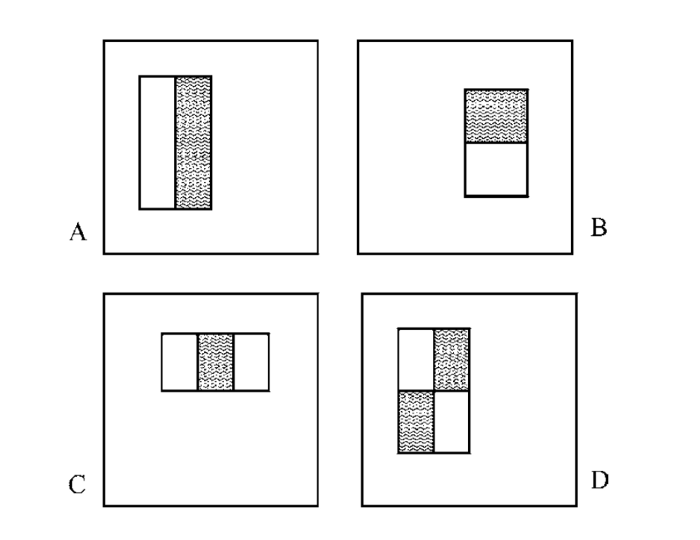

In [26]:
# This class is inspired by Anmol's implementation of Viola Jones algorithm
# Link in references
class ViolaJones():
  def __init__(self, T = 15):
    self.T = T
    self.classifiers = []
    self.alphas = []
  

  def train(self, training_data, features, applied_features ,num_pos, num_neg):
    weights = np.zeros(len(training_data))
    print("Calculating Weights")
    for i in range(len(training_data)):
      image, classification = training_data[i]
      
      if classification == POSITIVE_CLASSIFICATION:
        weights[i] = 1 / (2 * num_pos) # multiply by 2 to normalize values to sum to 1
      else:
        weights[i] = 1 / (2 * num_neg)
    print("Finished Calculating Weights")

    X,y = applied_features

    for i in range(self.T):
      # Normalize weights...
      weights = weights / np.linalg.norm(weights)
      weak_classifiers = self.train_weak_classifiers_mt(X, y, features, weights)
      classifier, e, accuracy = self.select_best_classifier_mt(weak_classifiers, weights, training_data)
      ## Updating weights according to: https://miro.medium.com/max/657/1*YL7Km5a5NpQ-wJujo0rWzw.png
      beta = e / (1 - e)
      for j in range(len(accuracy)):
        weights[j] = weights[j] * beta ** (1 - accuracy[j])
      ## Alphas are computed according to: https://miro.medium.com/max/700/1*cIfKETbjBCjOVFOYYJjxrg.png
      alpha = log(1/beta)
      self.alphas.append(alpha)
      self.classifiers.append(classifier)
      print("Chose classifier: %s with accuracy: %f and alpha: %f" % (str(classifier), len(accuracy) - sum(accuracy), alpha))

  def __count_pos_neg(self, y, weights):
    weight_pos = 0
    weight_neg = 0

    for weight, label in zip(weights, y):
      if label == POSITIVE_CLASSIFICATION:
        weight_pos = weight_pos + weight
      else:
        weight_neg = weight_neg + weight
    
    return (weight_pos, weight_neg)

  def __get_sorting_key(self, x):
    return x[1]


  def train_weak_classifiers_mt(self, X, y, features, weights):
    print("Started training weak classifiers")
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time =", current_time)
    chunks = np.array_split(X, NUM_THREADS)
    pool = mp.Pool(mp.cpu_count())
    results = [pool.apply_async(self.train_weak_classifiers, args=(chunk, y, features, weights)) for chunk in chunks]
    pool.close()
    classifiers = []
    for result in results:
      _classifiers = result.get()  
      classifiers = np.concatenate((classifiers, _classifiers))
    print("Finished training weak classifiers")
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time =", current_time)
    return classifiers
    

  def train_weak_classifiers(self, X, y, features, weights):
    
    weight_pos, weight_neg = self.__count_pos_neg(y, weights)

    weak_classifiers = []
    num_features, __discarded = X.shape
    for i, feature in enumerate(X):
#       if len(weak_classifiers) % 1000 == 0 and len(weak_classifiers) > 0:
#         print("Trained %d classifiers for %d features" % (len(weak_classifiers), num_features))
    
      applied_features = sorted(
          zip(weights, feature, y),
          key=self.__get_sorting_key
      )

      pos_seen = 0
      neg_seen = 0

      pos_weights = 0
      neg_weights = 0

      min_error = float('inf')
      best_feature = None
      best_theta = None 
      best_p = None

      for weight, theta, label in applied_features:
        error_neg = neg_weights + weight_pos - pos_weights
        error_pos = pos_weights + weight_neg - neg_weights
        error = min(error_neg, error_pos)

        if error < min_error:
          min_error = error
          best_feature = features[i]
          best_theta = theta
          best_p = 1 if pos_seen > neg_seen else -1
        
        if label == POSITIVE_CLASSIFICATION:
          pos_seen = pos_seen + 1
          pos_weights = pos_weights + weight
        else:
          neg_seen = neg_seen + 1
          neg_weights = neg_weights + weight
      
      weak_classifier = WeakClassifier(best_feature, best_theta, best_p)
      weak_classifiers.append(weak_classifier)
    
    return weak_classifiers

  def select_best_classifier_mt(self, classifiers, weights, training_data_with_integral_images):
    print("Started counting errors")
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time =", current_time)
    chunks = np.array_split(classifiers, NUM_THREADS)
    pool = mp.Pool(mp.cpu_count())
    futures = []
    j = 0
    results = [pool.apply_async(self.select_best_classifier, args=(chunk, weights, training_data_with_integral_images)) for chunk in chunks]
    pool.close()
    errors = []
    for result in results:
      error = result.get()  
      errors.append((error[0], j*len(chunks[j]) + error[1], error[2]))
      j = j + 1
    classifier, e, acc = min(errors, key=operator.itemgetter(1))
    print("Finished counting errors")
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time =", current_time)
    return classifier, e, acc
        
  def select_best_classifier(self, classifiers, weights, training_data_with_integral_images):

    best_classifier = None
    best_error = float('inf')
    best_accuracy = None
    errors = []
    divisor = len(training_data_with_integral_images);
    zipped = zip(training_data_with_integral_images, weights)
    num_classifiers = len(classifiers)
    for i in range(num_classifiers):
      error = 0
      classifier = classifiers[i]
      accuracy = []
      for j in range(divisor):
        data = training_data_with_integral_images[j]
        weight = weights[j]
        integral_image, classification = data
        prediction = classifier.classify(integral_image)
        is_incorrect = abs(prediction - classification)
        accuracy.append(is_incorrect)
        error = error + weight * is_incorrect
      
      errors.append((error / divisor, i, accuracy));
      
    e, idx, acc = min(errors, key=operator.itemgetter(0))
    return classifiers[idx], e, acc


 

  def classify(self, image):
    ## Final classification is computed according to: https://miro.medium.com/max/700/1*cIfKETbjBCjOVFOYYJjxrg.png
    classification_sum = 0
    alpha_sum = 0
    integral_image = get_integral_image(image)
    for alpha, classifier in zip(self.alphas, self.classifiers):
      classification_sum = classification_sum + (alpha * classifier.classify(integral_image))
      alpha_sum = alpha_sum + alpha
    if classification_sum >= 0.5 * alpha_sum:
      return POSITIVE_CLASSIFICATION
    return NEGATIVE_CLASSIFICATION

  def save(self, filename):
    with open(filename, "wb") as file:
      pickle.dump(self, file)
  
  @staticmethod
  def load(filename):
    with open(filename, "rb") as file:
      return pickle.load(file)



#### Weak Classifier

h(x) = 1 if p.f(x) < p.theta

h(x) = 0, otherwise

In [7]:
class WeakClassifier():
  def __init__(self, feature, theta, p):
    # self.pos_regions = pos_regions;
    # self.feature = ([pos_regions], [neg_regions])
    self.feature = feature
    # self.neg_regions = neg_regions;
    self.theta = theta;
    self.p = p;
  

  def classify(self, integral_image):
    applied_feature = get_applied_feature(integral_image, self.feature)
    if self.p * applied_feature < self.p * self.theta:
      return POSITIVE_CLASSIFICATION
    return NEGATIVE_CLASSIFICATION


#### Cascade Classifier

Cascade Classifier as presented in the Viola Jones Paper with AdaBoost to improve classfication speed to allow for Real time Face detection


In [8]:
class CascadeClassifier():
  def __init__(self, feature_numbers = [1, 5, 10, 50, 100]):
    self.feature_numbers = feature_numbers
    self.classifiers = []

  def train(self, training_data, features, applied_features):
    pos = []
    neg = []
    print("Counting Pos & neg Samples")
    for sample in training_data:
      image, classification = sample
      if classification == POSITIVE_CLASSIFICATION:
        pos.append(sample)
      else:
        neg.append(sample)
        
    print("Finished Counting Samples with %d pos & %d neg" % (len(pos), len(neg)))

    for num_features in self.feature_numbers:
      if len(neg) == 0:
        print("len(neg) == 0, STOPPING! FPR = 0")
        break
        
      print("Started Training ViolaJones with %d features" % (num_features))  
      classifier = ViolaJones(num_features)
      classifier.train(training_data, features, applied_features, len(pos), len(neg))
      self.classifiers.append(classifier)
      false_positives = []
      print("Finished Training ViolaJones with %d features" % (num_features))  
      print("Started counting false positives")  
      for sample in neg:
        image, classification = sample
        if self.classify(image) == POSITIVE_CLASSIFICATION:
          false_positives.append(sample)
      neg = false_positives
      print("Found %d False positives" % (len(neg)))  
  
  def classify(self, image):
    for i in range(len(self.classifiers)):
      if self.classifiers[i].classify(image) == NEGATIVE_CLASSIFICATION:
        return NEGATIVE_CLASSIFICATION
    return POSITIVE_CLASSIFICATION

  def save(self, filename):
    with open(filename, "wb") as file:
      pickle.dump(self, file)
  
  @staticmethod
  def load(filename):
    with open(filename, "rb") as file:
      return pickle.load(file)


#### Training Data Preprocessing

In [14]:


def get_integral_images(training_data):
  training_data_with_integral_images = []
  for image, classification in training_data:
    integral_image = get_integral_image(image)
    training_data_with_integral_images.append((integral_image, classification))

  return training_data_with_integral_images



def get_features(width, height):
  features = []
  # Brute force to get all possible features...
  for x in range(1, width + 1):
    for y in range(1, height + 1):
      i = 0
      while i + x < width:
        j = 0
        while j + y < height:
          current_region = create_rectangular_region(i, j, x, y)
          to_the_right = create_rectangular_region(i+x, j, x, y)
          
          true_right = False
          if i + 2 * x < width:
            true_right = True
            features.append(([to_the_right], [current_region]))
          
          to_the_bottom = create_rectangular_region(i, j+y, x, y)
            
          true_bottom = False
          if j + 2 * y < height:
            true_bottom = True
            features.append(([current_region], [to_the_bottom]))
            
          to_the_second_right = create_rectangular_region(i+2*x, j, x, y)
            
          if i + 3 * x < width:
            features.append(([to_the_right], [to_the_second_right, current_region]))
            
          to_the_second_bottom = create_rectangular_region(i, j+2*y, x, y)
            
          if j + 3 * y < height:
            features.append(([to_the_bottom], [to_the_second_bottom, current_region]))

          to_right_then_bottom = create_rectangular_region(i + x, j + y, x, y)

          if true_right and true_bottom:
            features.append((
                [to_the_right, to_the_bottom],
                [current_region, to_right_then_bottom]
            ))
          j = j + 1
        i = i + 1
  return features



def apply_features(features, training_data_with_integral_images):
  data = np.zeros((len(features), len(training_data_with_integral_images)))
  classifications = np.array(list(map(lambda data: data[1], training_data_with_integral_images)))
  i = 0
  for feature in features:
    data_row = []
    for integral_image, classification in training_data_with_integral_images:
      data_row.append(get_applied_feature(integral_image, feature))
    data[i] = data_row
    i = i + 1
  return data, classifications

with open("./training.pkl", "rb") as file:
  training_data = pickle.load(file)


print("Preprocessing Data Set...")
print("Getting integral images")
training_data_with_integral_images = get_integral_images(training_data)
w,h = training_data_with_integral_images[0][0].shape
print("Finished Generating integral images with shape %d x %d" % (w, h))
print("Getting Features");
width, height = training_data_with_integral_images[0][0].shape
features = get_features(width, height)

print("Finished getting features with a total number of %d" % (len(features)))

print("Applying features..")

# applied_features = apply_features(features, training_data_with_integral_images)
with open("./applied_features.pkl", "rb") as file:
    applied_features = pickle.load(file)

## Select best 5% features...

feature_indices = SelectPercentile(f_classif, percentile=5).fit(applied_features[0].T, applied_features[1]).get_support(indices=True)


    
print("Finished Applying features")

training_data = training_data_with_integral_images


Preprocessing Data Set...
Getting integral images
Finished Generating integral images with shape 19 x 19
Getting Features
Finished getting features with a total number of 51705
Applying features..
Finished Applying features


In [15]:
new_features = []
for idx in feature_indices:
    new_features.append(features[idx])
features = new_features
applied_features = (applied_features[0][feature_indices], applied_features[1])


In [16]:
print("Saving applied features")

with open("./applied_features_selected.pkl", "wb") as file:
    pickle.dump(applied_features, file)


# with open("./applied_features.pkl", "wb") as file:
#     pickle.dump(applied_features, file)

    
with open("./features_selected.pkl", "wb") as file:
    pickle.dump(features, file)

Saving applied features


### Testing & Training

In [29]:
def evaluate(classifier, data):
  num_correct_classifications = 0
  for image, classification in data:
    if classifier.classify(image) == classification:
      num_correct_classifications = num_correct_classifications + 1
  
  print("Classified %d correctly out of %d samples" % (num_correct_classifications, len(data)))

def train(num_features, filename):

  print("Started Training")
  pos, neg = [], []
  for sample in training_data:
      image, classification = sample
      if classification == POSITIVE_CLASSIFICATION:
        pos.append(sample)
      else:
        neg.append(sample)
        
  print("Finished Counting Samples with %d pos & %d neg" % (len(pos), len(neg)))

  print("Started Training ViolaJones with %d features" % (num_features))  
  classifier = ViolaJones(num_features)
  classifier.train(training_data, features, applied_features, len(pos), len(neg))
    
  with open("./training.pkl", "rb") as file:
    _training_data = pickle.load(file)
  evaluate(classifier, _training_data)
  classifier.save(filename)

def test(filename):
  with open("./test.pkl", "rb") as file:
    test_data = pickle.load(file)

  
  classifier = ViolaJones.load(filename)
  evaluate(classifier, test_data)


# train(200, "./num_feat_200.pkl")
test("./num_feat_200.pkl")




Classified 6653 correctly out of 6977 samples


In [47]:
def get_accuracies(classifier_filename, filename):
    with open(filename, "rb") as file:
        data = pickle.load(file)
    num_correct_classifications = 0
    now = datetime.now().timestamp() * 1000
    classifier = ViolaJones.load(classifier_filename)
    for image, classification in data:
        if classifier.classify(image) == classification:
            num_correct_classifications = num_correct_classifications + 1
  
    then = datetime.now().timestamp() * 1000
    print("Classified %d correctly out of %d samples" % (num_correct_classifications, len(data)))
    print("Accuracy: %.3f%%" % (100 * num_correct_classifications / len(data)))
    print("Avg Classification Time per 19x19 image: %.3fms" % ((then - now) / len(data)))
    
    
print("Test data set accuracy:")
get_accuracies("./num_feat_200.pkl", "./test.pkl")
print("------------")
print("Training data set accuracy:")
get_accuracies("./num_feat_200.pkl", "./training.pkl")
print("------------")

Test data set accuracy:
Classified 23081 correctly out of 24045 samples
Accuracy: 95.991%
Avg Classification Time per 19x19 image: 1.457ms
------------
Training data set accuracy:
Classified 6653 correctly out of 6977 samples
Accuracy: 95.356%
Avg Classification Time per 19x19 image: 1.429ms
------------


'13.95'

1620005548167.784

### References

1. https://towardsdatascience.com/understanding-face-detection-with-the-viola-jones-object-detection-framework-c55cc2a9da14
2. https://medium.datadriveninvestor.com/understanding-and-implementing-the-viola-jones-image-classification-algorithm-85621f7fe20b
3. https://medium.com/datadriveninvestor/understanding-and-implementing-viola-jones-part-two-97ae164ee60f 